In [1]:
import pandas as pd
from matplotlib import pyplot as py
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [2]:
df = pd.read_excel("premiums_young.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [3]:
df.shape

(20096, 13)

In [4]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [5]:
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [6]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Handle NA Value

In [7]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
df.shape

(20090, 13)

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [11]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-3, -1])

In [12]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [13]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

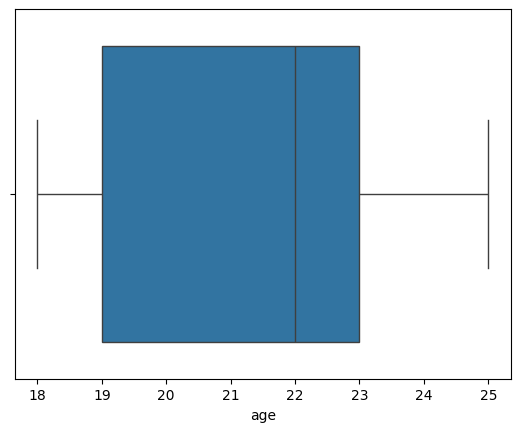

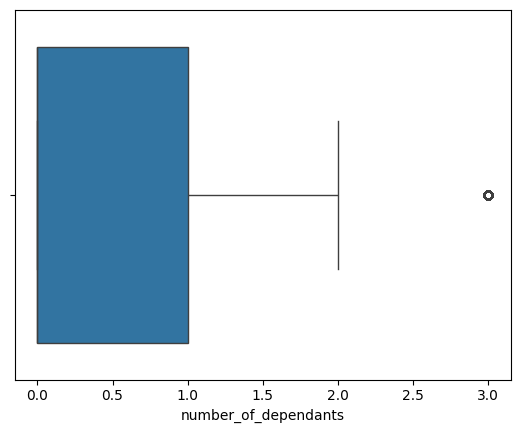

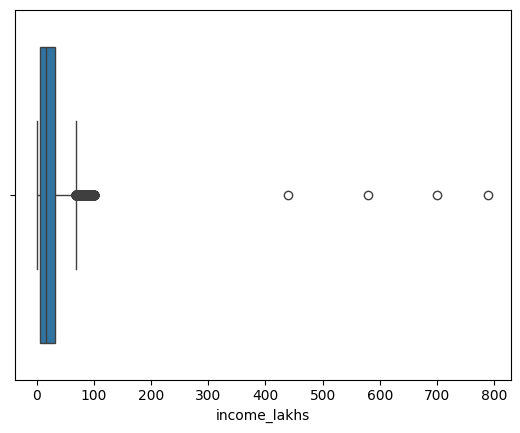

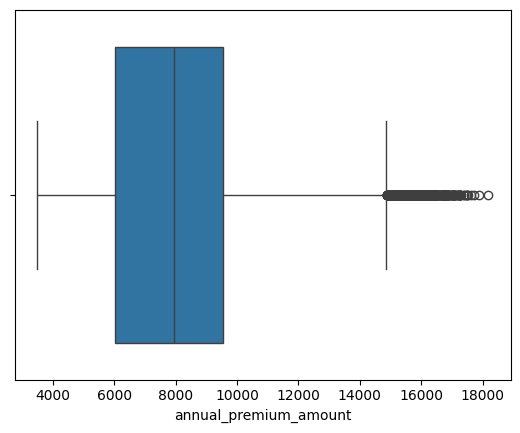

In [14]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    py.show()

In [15]:
df[df.age>100].shape

(0, 13)

In [16]:
df[df.age>100]["age"].unique()

array([], dtype=int64)

In [17]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [18]:
df.income_lakhs.quantile([0.25,0.75])

0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [19]:
def get_iqr_bonds(col1):
    Q1,Q3 = df.income_lakhs.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5* IQR
    return lower_bound,upper_bound

In [20]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [21]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


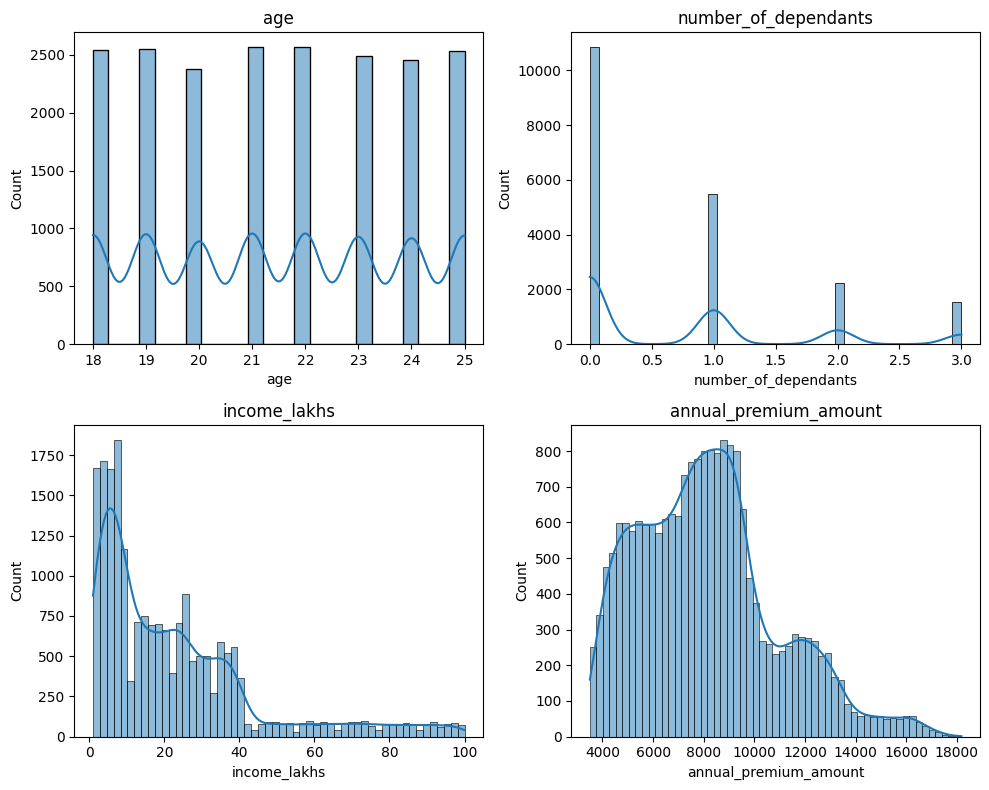

In [22]:
fig,axs = py.subplots(nrows=2,ncols=2,figsize=(10,8))

for i,col in enumerate(numeric_columns):
    ax = axs[i//2,i%2]
    sns.histplot(df2[col],kde=True,ax=ax)
    ax.set_title(col)

py.tight_layout()
py.show()

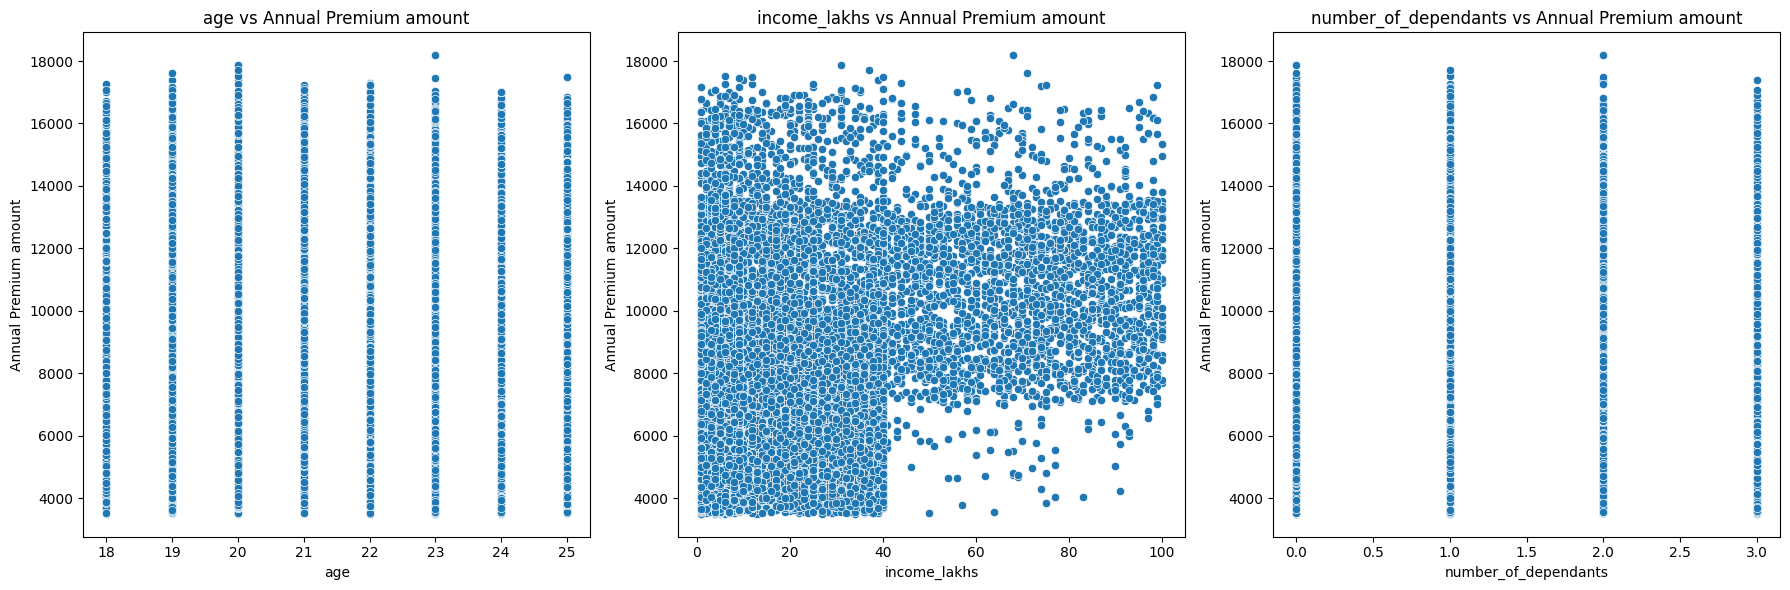

In [23]:
numeric_features = ["age","income_lakhs","number_of_dependants"]

fig,axes = py.subplots(1,len(numeric_features),figsize=(18,6))

for ax,column in zip(axes,numeric_features):
    sns.scatterplot(x=df2[column],y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f"{column} vs Annual Premium amount")
    ax.set_xlabel(column)
    ax.set_ylabel("Annual Premium amount")

py.tight_layout()
py.show()

In [24]:
categorical_columns = ["gender","region","marital_status","bmi_category","smoking_status","employment_status","income_level"
                      ,"medical_history","insurance_plan"]
for col in categorical_columns:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [25]:
df2["smoking_status"].replace({
    'Smoking=0':"No Smoking",
    "Not Smoking":'No Smoking',
    "Does Not Smoke":"No Smoking"
},inplace=True)

df2["smoking_status"].unique()

C:\Users\91999\AppData\Local\Temp\ipykernel_328\2825346143.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [26]:
categorical_columns = ["gender","region","marital_status","bmi_category","smoking_status","employment_status","income_level"
                      ,"medical_history","insurance_plan"]
for col in categorical_columns:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [27]:
pct_count = df2["gender"].value_counts(normalize=True)
pct_count

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

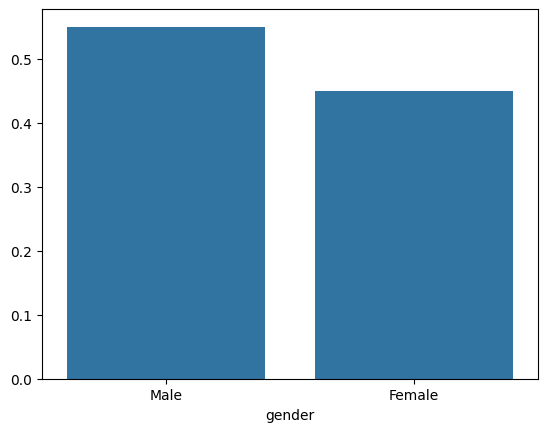

In [28]:
sns.barplot(x=pct_count.index,y=pct_count.values)
py.show()

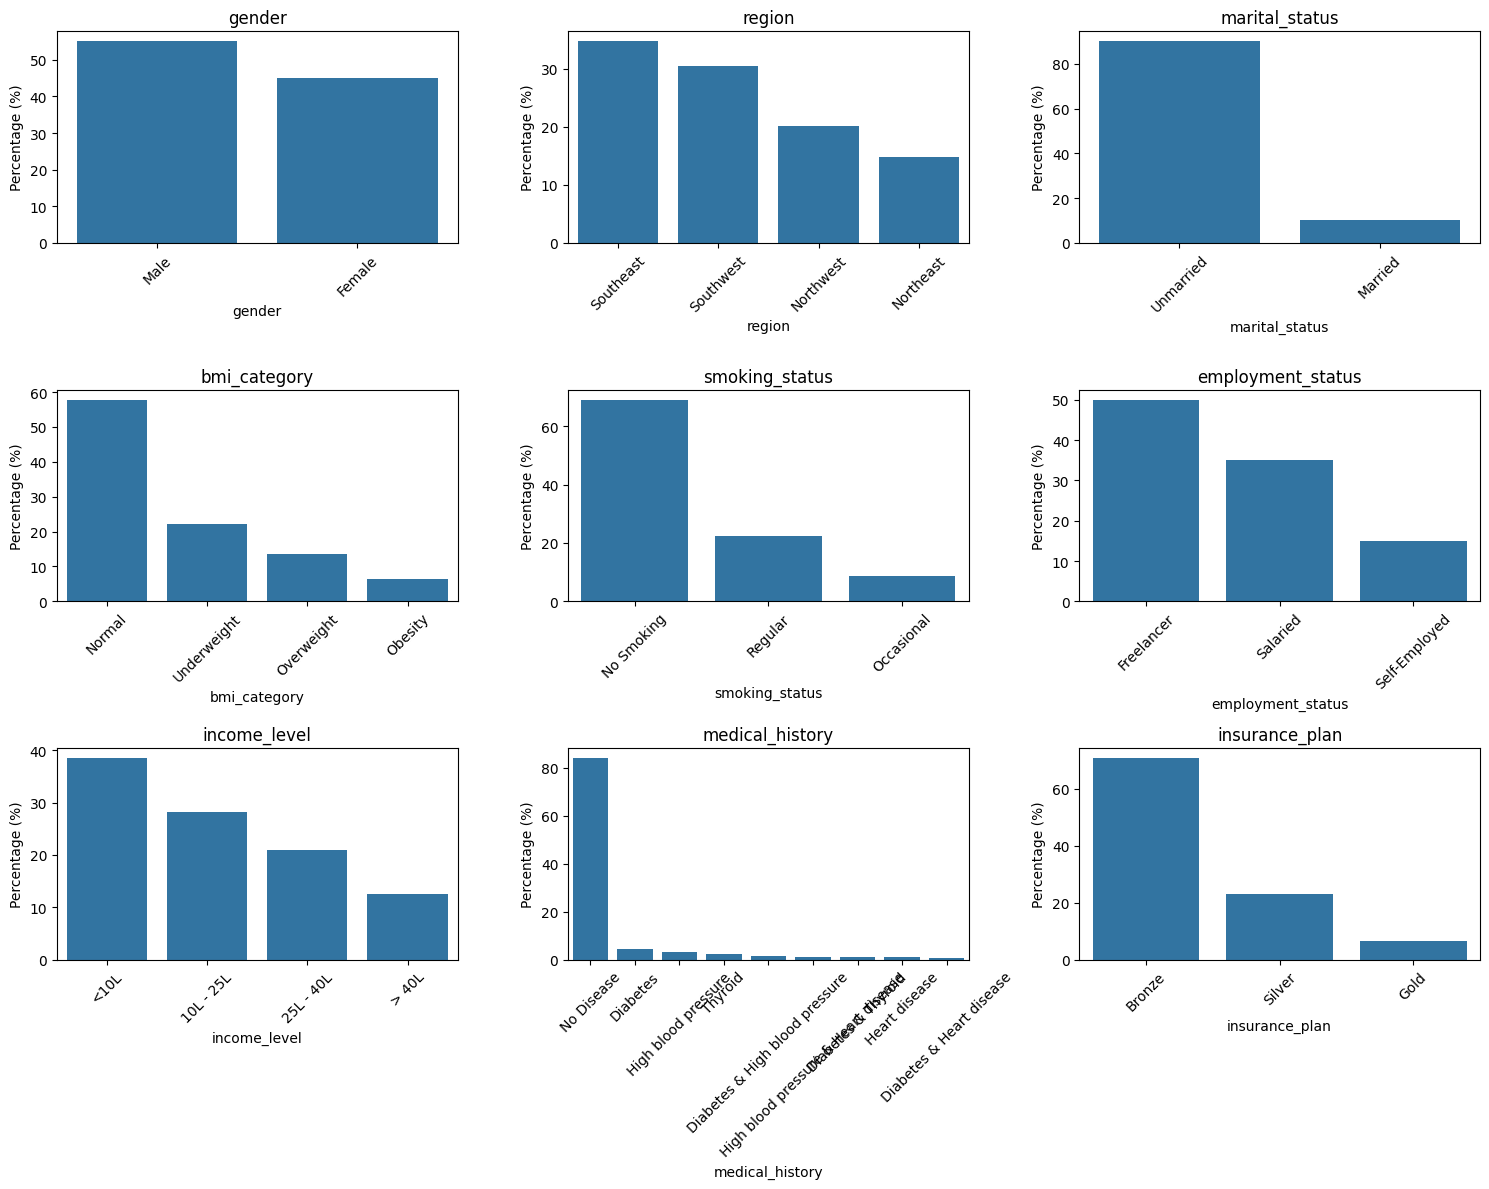

In [29]:
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # ensures enough rows

fig, axes = py.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # flatten in case of extra axes

for i, col in enumerate(categorical_columns):
    ax = axes[i]
    pct_count = df2[col].value_counts(normalize=True) * 100
    sns.barplot(x=pct_count.index, y=pct_count.values, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(col)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Remove any unused subplots
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

py.tight_layout()
py.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


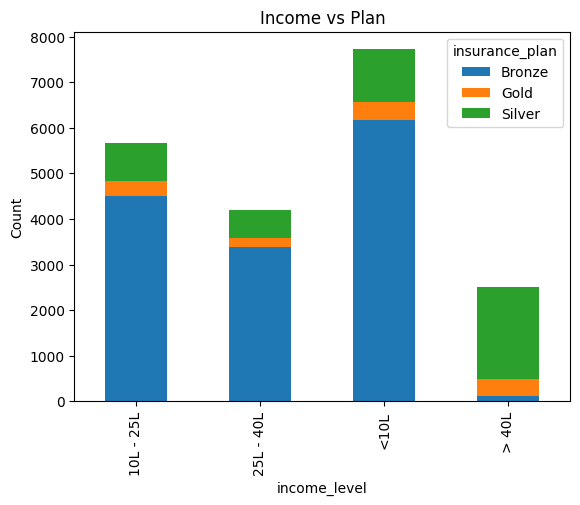

In [30]:
crosstab = pd.crosstab(df2["income_level"],df2["insurance_plan"])
print(crosstab)

crosstab.plot(kind="bar",stacked=True)
py.title("Income vs Plan")
py.ylabel('Count')
py.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

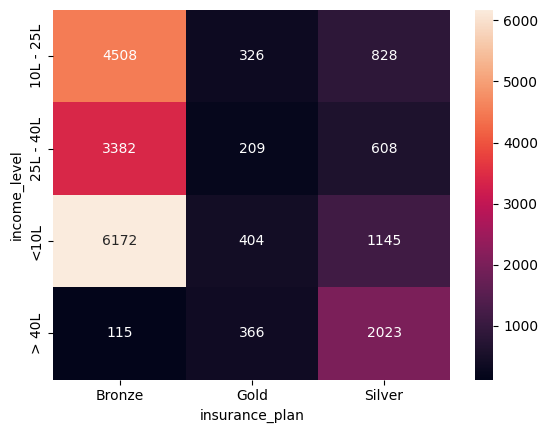

In [31]:
sns.heatmap(crosstab,annot=True,fmt="d")

In [32]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


In [33]:
df2["medical_history"].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [34]:
risk_scores = {
    "diabetes":6,
    "heart disease":8,
    "high blood pressure":6,
    "thyroid":5,
    "no disease":0,
    "none":0
}

df2[["disease1","disease2"]] = df2["medical_history"].str.split(" & ",expand=True).apply(lambda x:x.str.lower())
df2

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20091,18,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,91,No Disease,Gold,11603,no disease,None
20092,23,Female,Northwest,Unmarried,0,Obesity,Occasional,Freelancer,> 40L,57,Diabetes,Gold,14498,diabetes,None
20093,24,Female,Northwest,Unmarried,0,Underweight,No Smoking,Self-Employed,25L - 40L,35,No Disease,Bronze,9111,no disease,None
20094,21,Male,Northwest,Unmarried,0,Normal,Regular,Freelancer,25L - 40L,32,No Disease,Bronze,8564,no disease,None


In [35]:
df2["disease1"].fillna("none",inplace=True)
df2["disease2"].fillna("none",inplace=True)
df2["total_risk_score"] = 0

for disease in ["disease1","disease2"]:
    df2["total_risk_score"] += df2[disease].map(risk_scores)

max_score = df2["total_risk_score"].max()
min_score = df2["total_risk_score"].min()

df2["normalized_risk_score"] = (df2["total_risk_score"]-min_score)/(max_score-min_score)
df2.head(5)

C:\Users\91999\AppData\Local\Temp\ipykernel_328\2819023519.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["disease1"].fillna("none",inplace=True)
C:\Users\91999\AppData\Local\Temp\ipykernel_328\2819023519.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,no disease,none,0,0.000000


In [36]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
15353,25,Female,Northwest,Unmarried,1,Overweight,No Smoking,Freelancer,<10L,8,Diabetes & High blood pressure,Bronze,8777,diabetes,high blood pressure,12,0.857143
18298,20,Female,Southeast,Unmarried,0,Normal,No Smoking,Self-Employed,> 40L,64,No Disease,Silver,10024,no disease,none,0,0.000000
7636,19,Female,Southeast,Unmarried,1,Overweight,No Smoking,Salaried,<10L,1,No Disease,Bronze,8152,no disease,none,0,0.000000
2129,19,Male,Southwest,Unmarried,0,Overweight,No Smoking,Salaried,25L - 40L,31,No Disease,Bronze,4744,no disease,none,0,0.000000
1160,21,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,<10L,3,No Disease,Bronze,4041,no disease,none,0,0.000000
12545,20,Female,Northeast,Unmarried,0,Obesity,No Smoking,Self-Employed,<10L,6,No Disease,Bronze,6404,no disease,none,0,0.000000
14726,24,Male,Southeast,Unmarried,1,Underweight,No Smoking,Freelancer,<10L,5,No Disease,Silver,11489,no disease,none,0,0.000000
5857,21,Male,Southeast,Unmarried,1,Normal,Regular,Self-Employed,25L - 40L,25,No Disease,Bronze,4857,no disease,none,0,0.000000
16597,23,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,25L - 40L,30,No Disease,Bronze,8123,no disease,none,0,0.000000
3488,18,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,<10L,7,No Disease,Bronze,5538,no disease,none,0,0.000000


In [37]:
df2["insurance_plan"] = df2["insurance_plan"].map({"Bronze":1,"Silver":2,"Gold":3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [38]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [39]:
df2["income_level"] = df2["income_level"].map({'<10L':1,'10L - 25L':2,'25L - 40L':3,'> 40L':4})
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,2,14,No Disease,1,5712,no disease,none,0,0.000000


In [40]:
nominal_cols = ["gender","region","marital_status","bmi_category","smoking_status","employment_status"]

df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [41]:
df4 = df3.drop(["disease1","disease2","medical_history","total_risk_score"],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


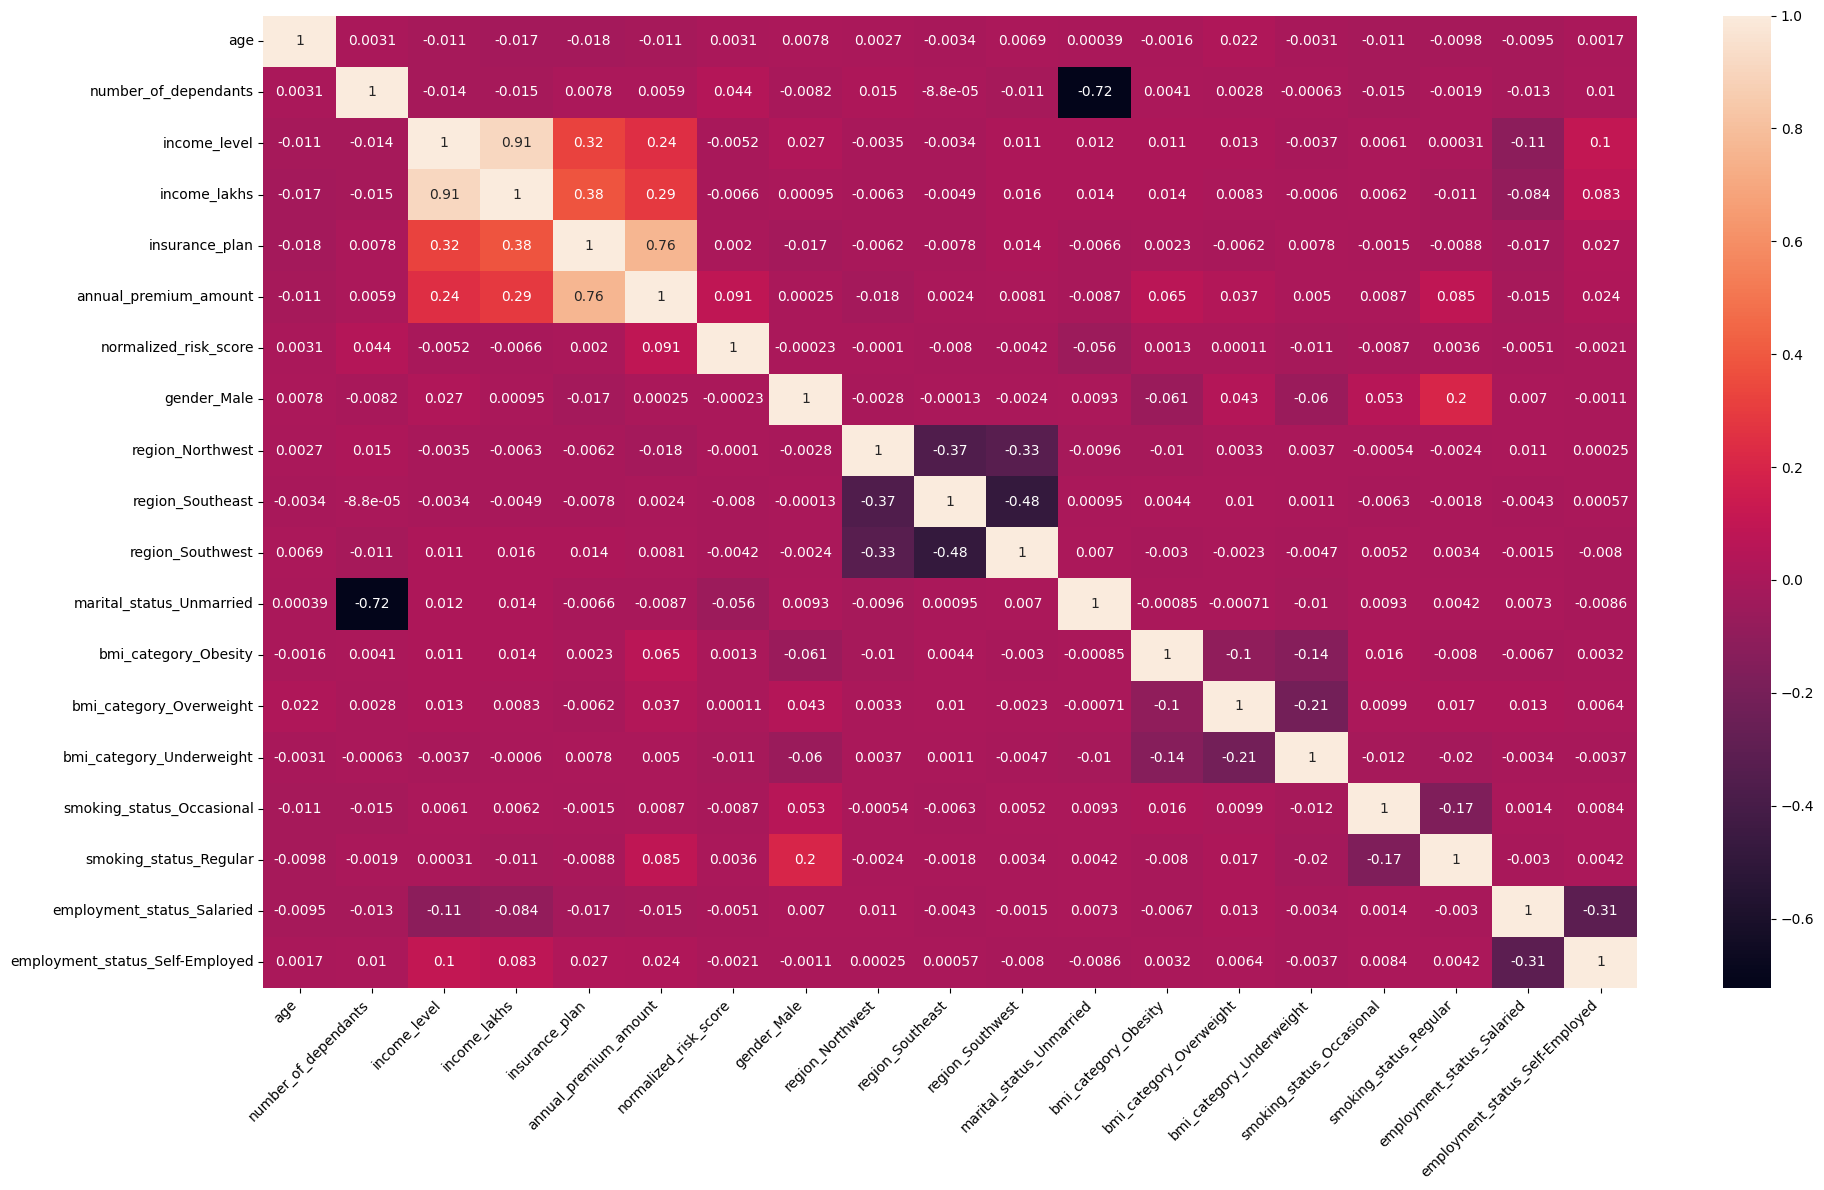

In [42]:
cm = df4.corr()

py.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
py.xticks(rotation=45,ha="right")
py.yticks(rotation=0)
py.tight_layout()
py.show()

In [43]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0


In [44]:
X = df4.drop("annual_premium_amount",axis=1)
Y = df4["annual_premium_amount"]

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ["age","number_of_dependants","income_level","income_lakhs","insurance_plan"]
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [46]:
calculate_vif(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [47]:
calculate_vif(X.drop("income_level",axis=1))

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [48]:
X_reduced = X.drop("income_level",axis=1)
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.333333,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Model Training

In [49]:
X_train,X_test,Y_train,Y_test = train_test_split(X_reduced,Y,test_size=0.3,random_state=10)

print("x train:",X_train.shape)
print("y test:",X_test.shape)
print("y train:",Y_train.shape)
print("y test:",Y_test.shape)

x train: (14060, 17)
y test: (6026, 17)
y train: (14060,)
y test: (6026,)


In [50]:
model_lr = LinearRegression()
model_lr.fit(X_train,Y_train)
test_score = model_lr.score(X_test,Y_test)
train_score = model_lr.score(X_train,Y_train)
train_score,test_score

(0.6020471274164894, 0.6047589163893645)

In [51]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

In [52]:
model_lr.intercept_

np.float64(6614.583391230755)

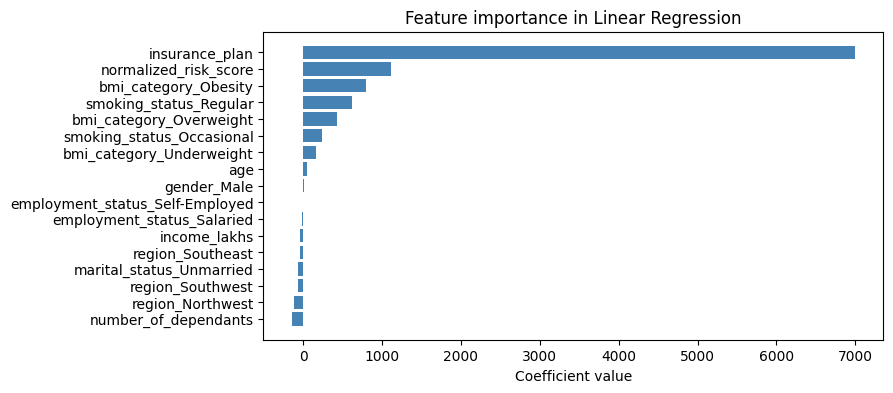

In [53]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances,index=X_test.columns,columns=["Coefficient"])
coef_df = coef_df.sort_values(by="Coefficient",ascending=True)

py.figure(figsize=(8,4))
py.barh(coef_df.index,coef_df["Coefficient"],color="steelblue")
py.title("Feature importance in Linear Regression")
py.xlabel("Coefficient value")
py.show()


In [54]:
model_ridge = Ridge()
model_ridge.fit(X_train,Y_train)
test_score = model_ridge.score(X_test,Y_test)
train_score = model_ridge.score(X_train,Y_train)
train_score,test_score

(0.6020466631305188, 0.6047715291063815)

In [55]:
model_ridge = Lasso()
model_ridge.fit(X_train,Y_train)
test_score = model_ridge.score(X_test,Y_test)
train_score = model_ridge.score(X_train,Y_train)
train_score,test_score

(0.6020070388600265, 0.6050530497921969)

In [56]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train,Y_train)
test_score = model_xgb.score(X_test,Y_test)
train_score = model_xgb.score(X_train,Y_train)
train_score,test_score

(0.7251046895980835, 0.5638787746429443)

In [57]:
model_xgb = XGBRegressor()

param_grid = {
    "n_estimators":[20,40,50],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
}

random_search = RandomizedSearchCV(model_xgb,param_grid,n_iter=10,cv=3,scoring='r2',random_state=42)
random_search.fit(X_train,Y_train)
random_search.best_score_

np.float64(0.5997088948885599)

In [94]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [58]:
best_model = model_lr

### Error Analysis

In [59]:
y_pred = best_model.predict(X_test)

residuals = y_pred-Y_test
residual_pct = residuals*100/Y_test


results_df = pd.DataFrame({
    'actual':Y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct':residual_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6625.420564,387.420564,6.210653
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185


<Axes: xlabel='diff_pct', ylabel='Count'>

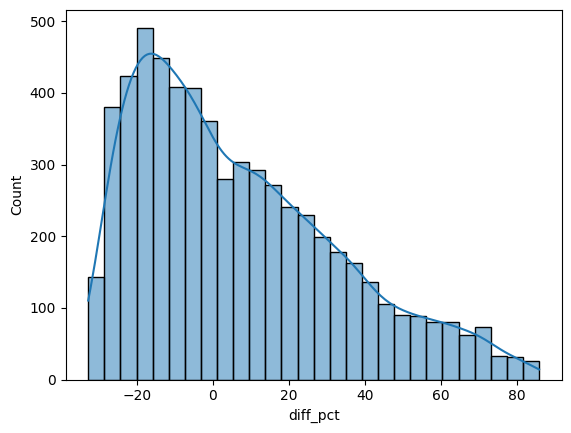

In [60]:
sns.histplot(results_df["diff_pct"],kde=True)

In [61]:
extreme_error_threshold = 10
extreme_result_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]

In [62]:
extreme_result_df.shape

(4404, 4)

In [63]:
extreme_error_pct = extreme_result_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

73.08330567540658

In [64]:
extreme_result_df.index

Index([14758, 13205, 14278, 19351, 10622, 14799, 16348,  5573,  5634, 14882,
       ...
       10266,  5484,  8988,  9658,  1365,   399, 17652,  5807, 10298, 13316],
      dtype='int64', length=4404)

In [65]:
extreme_errors_df = X_test.loc[extreme_result_df.index]
extreme_errors_df

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
14278,0.714286,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
19351,0.571429,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
10622,0.428571,0.333333,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.142857,0.666667,0.111111,0.0,0.785714,0,0,0,1,1,0,0,1,0,0,1,0
17652,0.571429,0.000000,0.343434,0.0,0.000000,1,0,0,0,1,0,0,0,0,0,1,0
5807,0.857143,0.333333,0.040404,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
10298,0.000000,0.000000,0.111111,0.5,0.000000,1,0,1,0,1,0,1,0,0,1,1,0


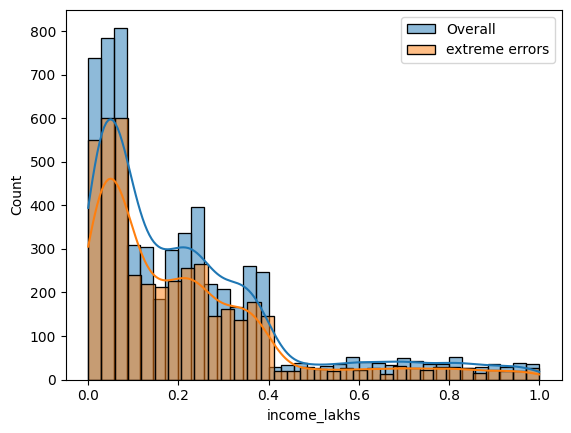

In [66]:
sns.histplot(X_test.income_lakhs,label="Overall",kde=True)
sns.histplot(extreme_errors_df.income_lakhs,label="extreme errors",kde=True)
py.legend()
py.show()

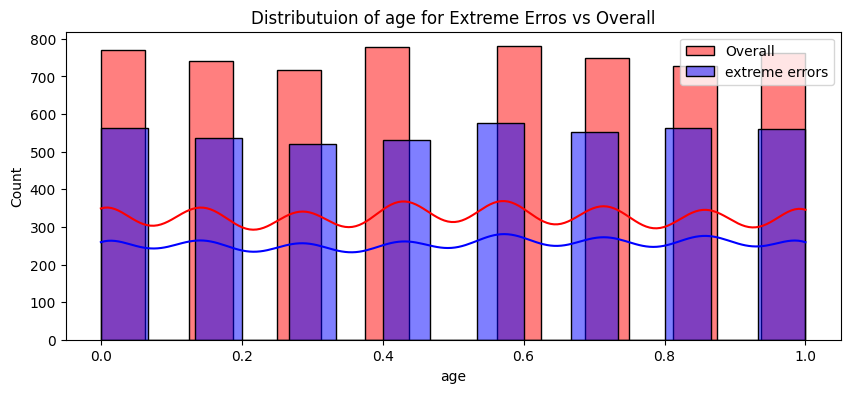

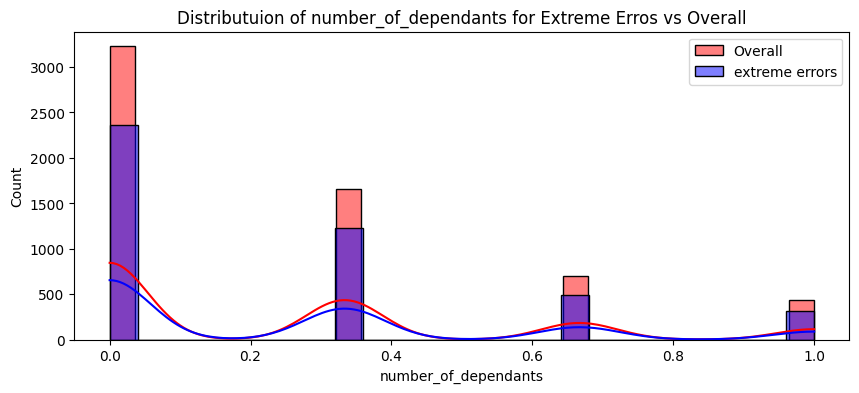

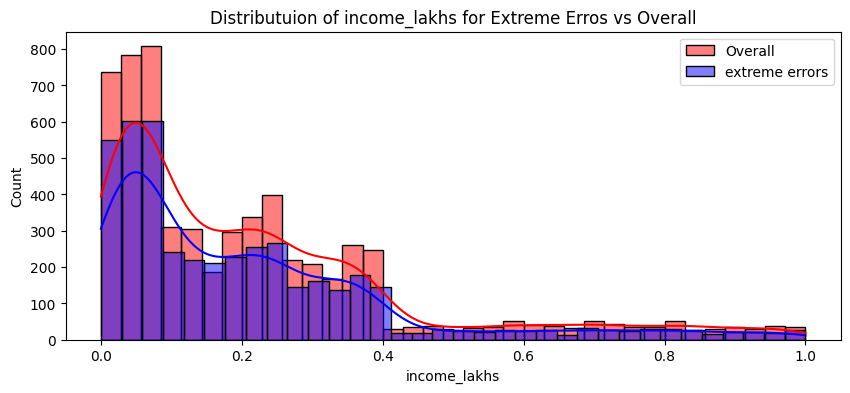

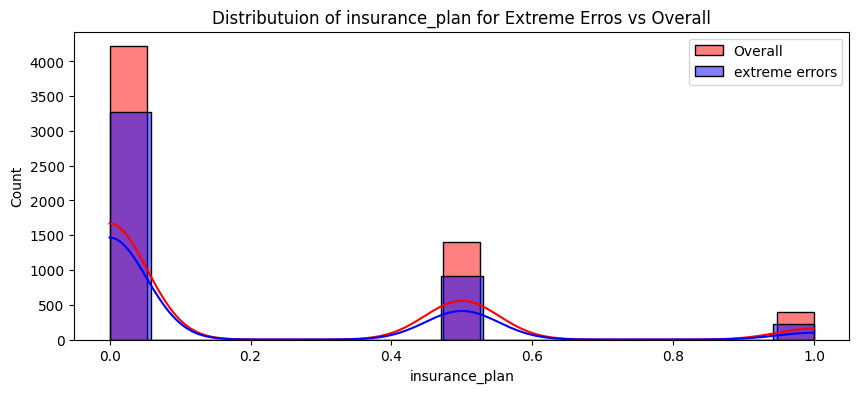

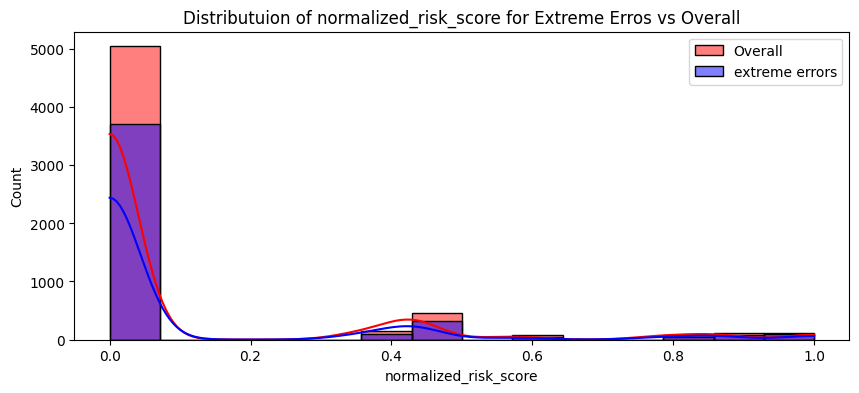

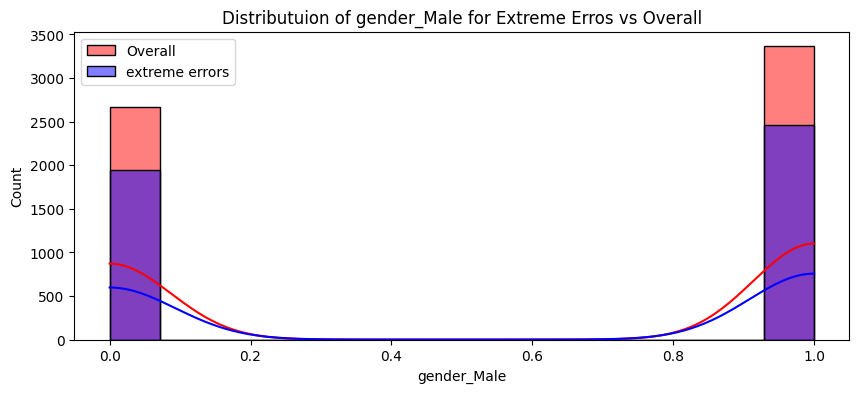

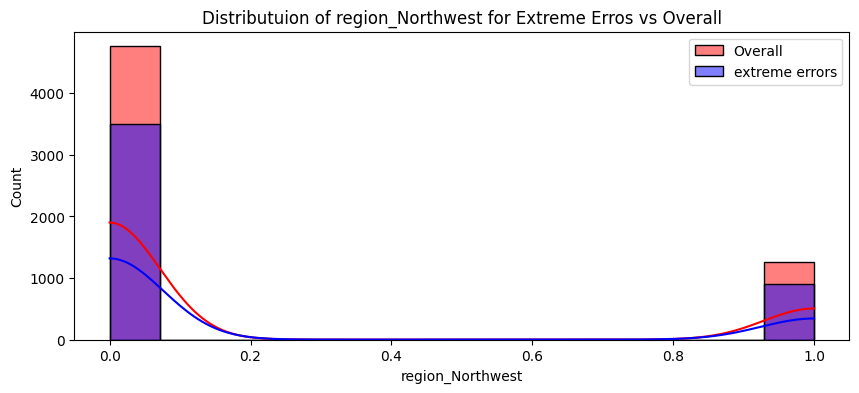

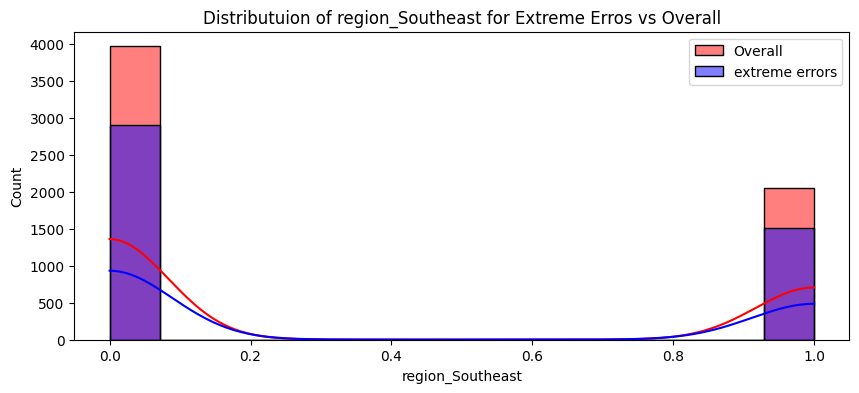

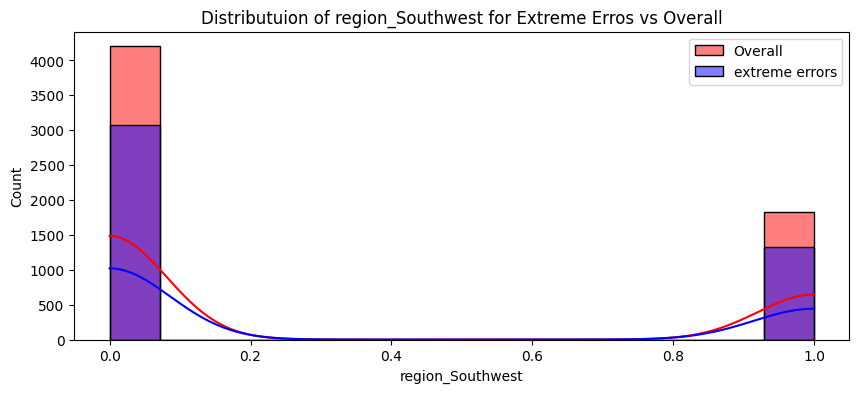

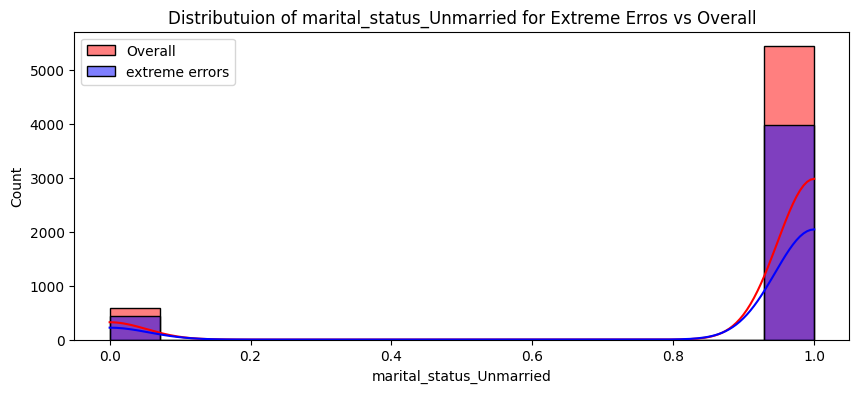

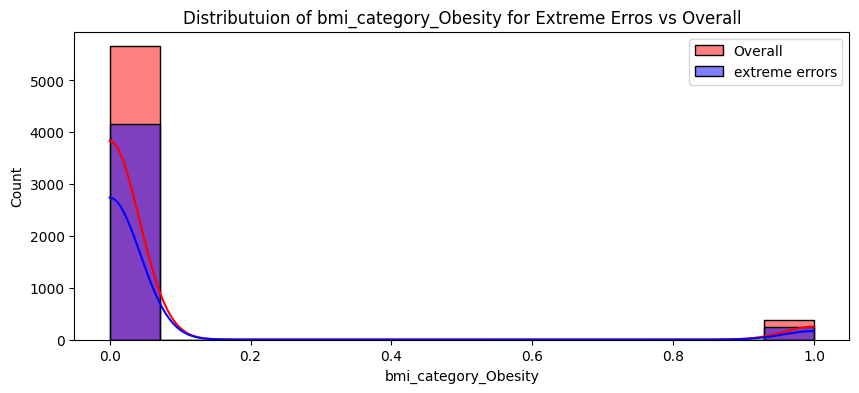

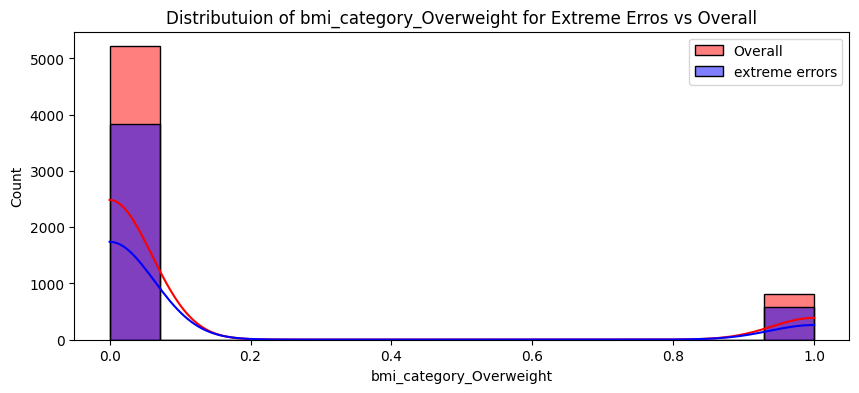

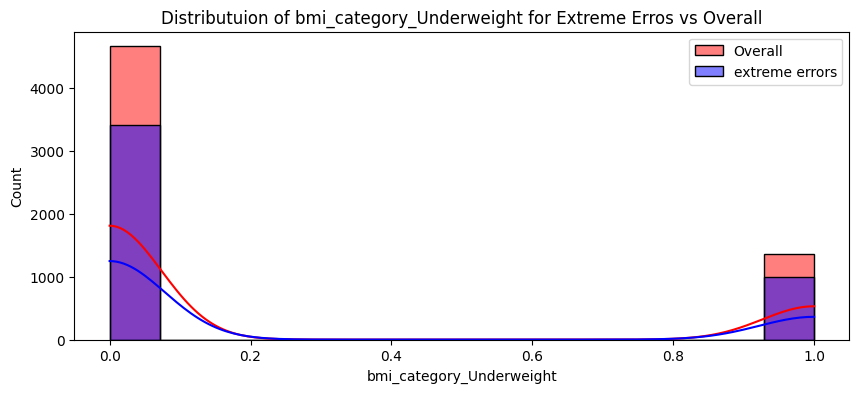

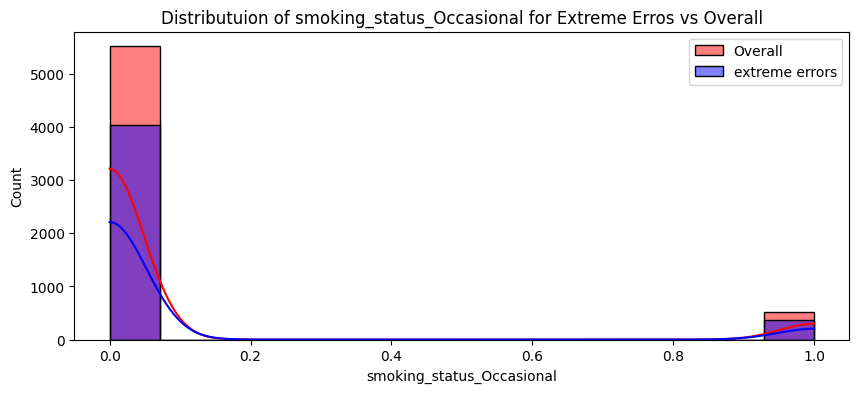

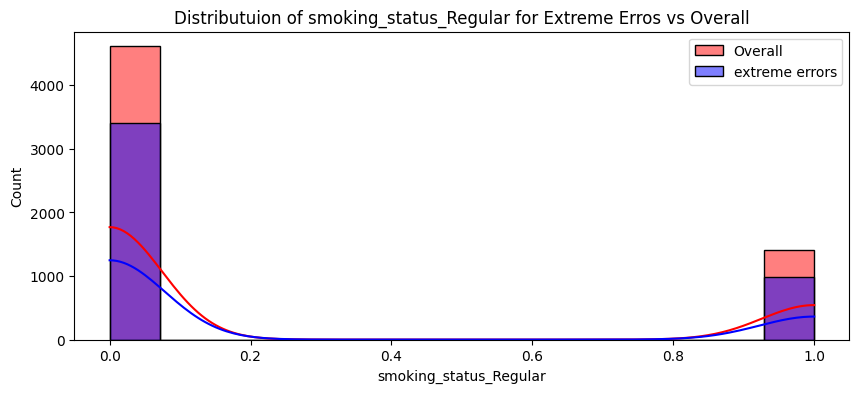

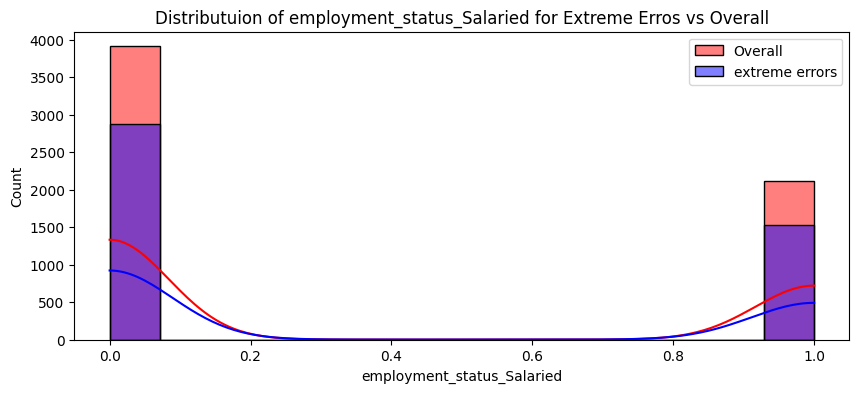

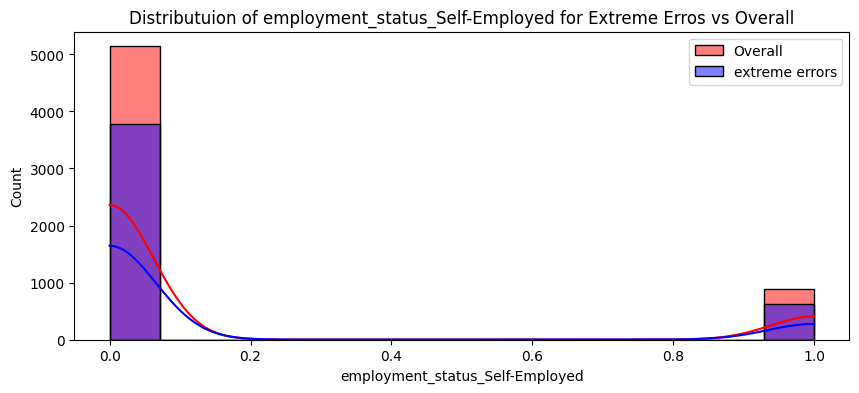

In [67]:
for feature in X_test.columns:
    py.figure(figsize=(10,4))
    sns.histplot(X_test[feature],label="Overall",color="red",kde=True)
    sns.histplot(extreme_errors_df[feature],color="blue",label="extreme errors",kde=True)
    py.legend()
    py.title(f"Distributuion of {feature} for Extreme Erros vs Overall")
    py.show()

<Axes: xlabel='age', ylabel='Count'>

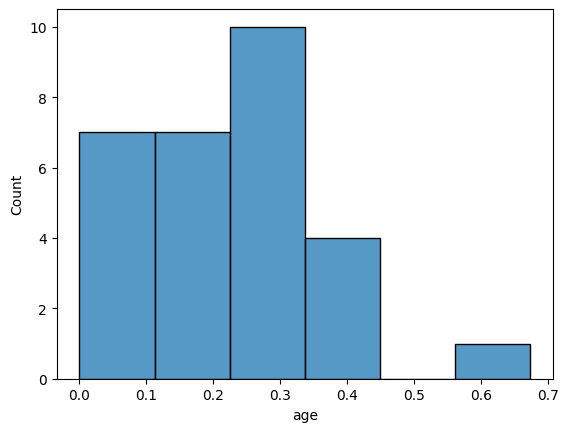

In [110]:
sns.histplot(extreme_errors_df.age)

In [111]:
extreme_errors_df["income_level"]=-1

<Axes: xlabel='age', ylabel='Count'>

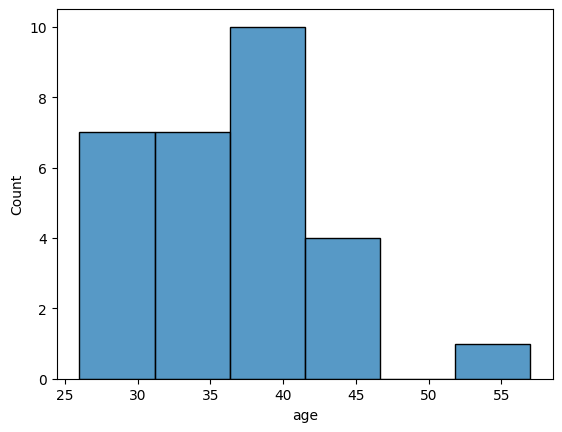

In [112]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = age_original = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
sns.histplot(df_reversed["age"])

In [113]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,29.000000,29.000000,29.0,29.000000,29.0
mean,36.586207,2.241379,-2.0,6.862069,1.0
std,6.811321,1.184880,0.0,7.619168,0.0
min,26.000000,0.000000,-2.0,1.000000,1.0
25%,32.000000,1.000000,-2.0,3.000000,1.0
50%,37.000000,3.000000,-2.0,5.000000,1.0
75%,40.000000,3.000000,-2.0,9.000000,1.0
max,57.000000,4.000000,-2.0,39.000000,1.0
